In [1]:
import ipywidgets as widgets
from IPython.display import HTML
import math
import os.path
import pandas as pd
import requests
import osr
import numpy as np
from osgeo import gdal
import affine
import matplotlib.pyplot as plt

# Download the LBDA data file

### Define url of directory and file name of data to download from NOAA

In [2]:
dataset_url = 'https://www1.ncdc.noaa.gov/pub/data/paleo/drought/LBDP-v2/'
dataset_filename = 'lbda-v2_kddm_pmdi_2017.nc'

### Specify where to download the data file

In [3]:
download_to_directory = widgets.Text(
    description = "Download to", value='/projects/skope/original/lbda_v2/')

download_status = widgets.Button(
    description = 'Download not started',
    disabled    = True
)

display(
    download_to_directory,
    download_status
)

Text(value='/projects/skope/original/lbda_v2/', description='Download to')

Button(description='Download not started', disabled=True, style=ButtonStyle())

### Download the single file in the dataset if not already downloaded

In [4]:
download_status.description = 'Downloading files'

destination_dir = download_to_directory.value
source_url = dataset_url + '/' + dataset_filename
destination_path = destination_dir + '/' + dataset_filename

if os.path.exists(destination_path):
    print(dataset_filename, "already downloaded")
else:        
    print("Downloading", dataset_filename)
    response = requests.get(source_url)
    assert response.status_code == 200
    with open(destination_path, 'wb') as f:  
        f.write(response.content)
    print("Finished downloading", dataset_filename)
    
download_status.description = 'Downloads complete'

lbda-v2_kddm_pmdi_2017.nc already downloaded


# Display properties of the downloaded data file

### Load the data file into a GDAL dataset object

In [5]:
# open the first GDD data file
dataset = gdal.Open(destination_path)

# confirm that a Dataset object was returned
assert str((type(dataset))) == "<class 'osgeo.gdal.Dataset'>"

# Confirm that dimensions of data set is 115 x 48 pixels and 2018 bands

In [6]:
# extract the dimensions from the data file 
extent_in_pixels_x = dataset.RasterXSize
extent_in_pixels_y = dataset.RasterYSize
band_count         = dataset.RasterCount

# confirm the dimensions are those expected
assert extent_in_pixels_x == 115
assert extent_in_pixels_y == 48
assert band_count         == 2018

# summarize the data file dimensions
print('Dimensions: %d x %d pixels and %d bands' % (extent_in_pixels_x, extent_in_pixels_y,  band_count))

Dimensions: 115 x 48 pixels and 2018 bands


### Load and display elements of the GDAL raster-to-projection coordinate transform

In [7]:
# get the transform from the data file
gt = dataset.GetGeoTransform()

# confirm that this indeed is a North-Up transformation, i.e. that
#    ignored elements of transform are both zero
assert gt[2] == 0
assert gt[4] == 0

# extract the origin and pixel dimensions from the transform
origin_x      = gt[0]
origin_y      = gt[3]
pixel_size_x  = abs(gt[1])
pixel_size_y  = abs(gt[5])

# summarize the transform
print("Origin:          %11.6f,%11.6f" % (origin_x, origin_y))
print("Pixel size:      %11.6f,%11.6f" % (pixel_size_x, pixel_size_y))
print("Pixels/degree:   %11.6f,%11.6f" % (1.0/pixel_size_x, 1.0/pixel_size_y))

Origin:          -124.500000,  49.000000
Pixel size:         0.500000,   0.500000
Pixels/degree:      2.000000,   2.000000


### Display output of gdalinfo

In [8]:
!gdalinfo $destination_path -nomd | head -12

Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Driver: netCDF/Network Common Data Format
Files: /projects/skope/original/lbda_v2//lbda-v2_kddm_pmdi_2017.nc
Size is 115, 48
Coordinate System is `'
Origin = (-124.500000000000000,49.000000000000000)
Pixel Size = (0.500000000000000,-0.500000000000000)
Corner Coordinates:
Upper Left  (-124.5000000,  49.0000000) 
Lower Left  (-124.5000000,  25.0000000) 
Upper Right ( -67.0000000,  49.0000000) 
Lower Right ( -67.0000000,  25.0000000) 
Center      ( -95.7500000,  37.0000000) 


### Get metadata dictionary from data file

In [9]:
metadata = dataset.GetMetadata_Dict()
metadata_df = pd.DataFrame.from_dict(dataset.GetMetadata_Dict(), 'index')
pd.set_option('display.max_colwidth',100)
HTML(metadata_df.to_html(header=False,justify='left'))

lat#long_name,lat
lat#units,degrees_north
lon#long_name,lon
lon#units,degrees_east
NC_GLOBAL#title,Recalibration of Cook et al 2010 PMDI using GHCN 5km instrumental data and Kernel Density Distri...
NETCDF_DIM_EXTRA,{time}
NETCDF_DIM_time_DEF,"{2018,6}"
NETCDF_DIM_time_VALUES,"{0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,..."
PMDI#long_name,Palmer modified drought index
PMDI#_FillValue,nan
time#long_name,time


### Extract key metadata elements

In [10]:
variable_name        = metadata['PMDI#long_name']
variable_title       = metadata['NC_GLOBAL#title']
variable_units       = metadata['time#units']
variable_fillvalue   = metadata['PMDI#_FillValue']

print('Name       : %s' % (variable_name))
print('Units      : %s' % (variable_units))
print('Fill value : %s' % (variable_fillvalue))
print('Title      : %s' % (variable_title))


Name       : Palmer modified drought index
Units      : year_CE
Fill value : nan
Title      : Recalibration of Cook et al 2010 PMDI using GHCN 5km instrumental data and Kernel Density Distribution Method


# Analyze last band of downloaded data file

### Display properties of the last band

In [11]:
# get the last band
band = dataset.GetRasterBand(2018)

# print out key properties of the band
print('width in pixels      : %d' % (band.XSize))
print('height in pixels     : %d' % (band.YSize))
print('block size           : %s' % (band.GetBlockSize()))
print('units                : %s' % (band.GetUnitType()))
print('data type            : %s' % (gdal.GetDataTypeName(band.DataType)))
print('data type size (bits): %s' % gdal.GetDataTypeSize(band.DataType))
print('nodata value         : %f' % (band.GetNoDataValue()))

width in pixels      : 115
height in pixels     : 48
block size           : [115, 1]
units                : 
data type            : Float32
data type size (bits): 32
nodata value         : nan


### Access pixel values in band as a numpy array

In [12]:
# get band pixel values as a numpy array
band_array = band.ReadAsArray()
display(band_array)

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [1.37, 0.09, 1.15, ...,  nan,  nan,  nan],
       [1.69, 0.05, 1.63, ...,  nan,  nan,  nan],
       ...,
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]], dtype=float32)

### Define a mask covering just the nodata values

In [13]:
nodata_mask = np.isnan(band_array)
print(nodata_mask)

[[ True  True  True ...  True  True  True]
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


### Define a masked version of the band data array

In [14]:
masked_array = np.ma.array(band_array, mask = nodata_mask)
masked_array

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [1.3700000047683716, 0.09000000357627869, 1.149999976158142, ...,
         --, --, --],
        [1.690000057220459, 0.05000000074505806, 1.6299999952316284, ...,
         --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float32)

### Demonstrate that the statistics for the masked array ignore the masked NODATA values

In [15]:
print('max  : %7.4f' % (np.amax(masked_array)))
print('mean : %7.4f' % (np.mean(masked_array)))
print('min  : %7.4f' % (np.amin(masked_array)))

max  :  6.4300
mean :  0.4580
min  : -4.9800


### Demonstrate that contour plots ignore the masked NODATA values

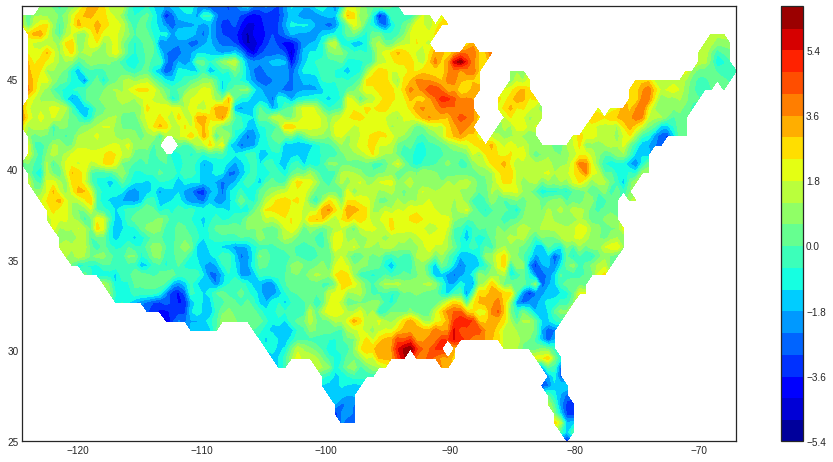

In [16]:
%matplotlib inline
plt.style.use('seaborn-white')

x = np.linspace(-124.5, -67, 115)
y = np.linspace(49, 25, 48)
fig = plt.figure(figsize=(16,8))
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, masked_array, 20, cmap='jet')
plt.colorbar();

# Analyze distribution of values in data set as a whole

### Load the entire dataset into a 3D nan-masked numpy array 
The array is indexed by: (**year**, **lat_index**, **long_index**)

In [17]:
full_dataset_array = dataset.GetVirtualMemArray()
full_dataset_mask = np.isnan(full_dataset_array)
full_dataset_masked_array = np.ma.array(full_dataset_array, mask = full_dataset_mask)
full_dataset_masked_array.shape

(2018, 48, 115)

### Compute min, max, and mean of values across entire dataset

In [18]:
dataset_min  = np.amin(full_dataset_masked_array)
dataset_max  = np.amax(full_dataset_masked_array)
dataset_mean = np.mean(full_dataset_masked_array)

print('max : %8.4f' % (dataset_max))
print('mean: %8.4f' % (dataset_mean))
print('min : %8.4f' % (dataset_min))


max :  17.6200
mean:  -0.0517
min : -13.7400


### Define floor and ceiling for histogram leaving one empty bin at start and end

In [19]:
dataset_ceiling = math.ceil(dataset_max) + 1
dataset_floor = math.floor(dataset_min) - 1
dataset_bin_count = dataset_ceiling - dataset_floor + 1

print('ceiling: %3d' % (dataset_ceiling))
print('floor  : %3d' % (dataset_floor))
print('bins   : %3d' % (dataset_bin_count))

ceiling:  19
floor  : -15
bins   :  35


### Digitize the dataset and stire counts of pixel values in each bin in a dataframe

In [20]:
bin_boundaries = np.linspace(dataset_floor, dataset_ceiling, dataset_bin_count)

digitized = np.digitize(full_dataset_masked_array, bin_boundaries, right=True)
digitize_indices, digitize_counts = np.unique(digitized, return_counts=True)
bin_starts = bin_boundaries[:-1]

bin_counts = [0 for x in range(dataset_ceiling - dataset_floor + 1)]
for key, value in zip(digitize_indices, digitize_counts):
    bin_counts[key-1] = value

bins = pd.DataFrame({'gte': bin_starts, 'lt': bin_starts+1, 'count': bin_counts[:-1]})
HTML(bins.to_html(index=False))

gte,lt,count
-15.0,-14.0,0
-14.0,-13.0,2
-13.0,-12.0,10
-12.0,-11.0,20
-11.0,-10.0,76
-10.0,-9.0,218
-9.0,-8.0,511
-8.0,-7.0,1441
-7.0,-6.0,5075
-6.0,-5.0,18413


### Plot the histogram

<BarContainer object of 34 artists>

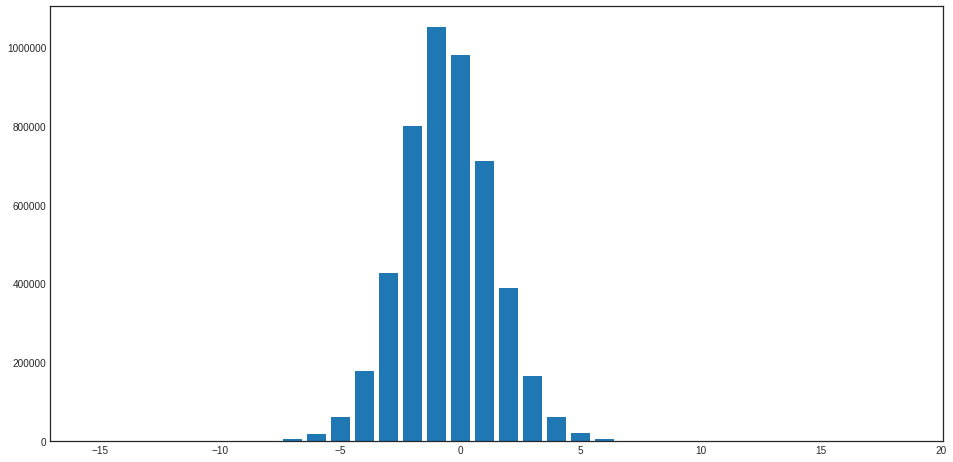

In [21]:
plt.figure(figsize=(16,8))
plt.bar(x=bins['gte'], height=bins['count'])

# Analyze distribution of missing (NaN) values in data set

### Count NODATA pixels in each year of data

In [22]:
missing_data_by_year = [ np.count_nonzero(full_dataset_mask[year-1]) 
                            for year in range(1,2019) ]
#missing_data_by_year_df = pd.DataFrame({'year': range(1,2019), 'NODATA pixels': missing_data_by_year})
#HTML(missing_data_by_year_df.to_html(index=False))

### Confirm that going forward in time no year introduces NODATA values at new positions

In [23]:
nodata_growth_years = []
nodata_loss_years = []

for i in range(0,2017):
    or_of_consecutive_years = np.logical_or(full_dataset_mask[i],full_dataset_mask[i+1])
    if not np.array_equal(or_of_consecutive_years, full_dataset_mask[i]):
        nodata_growth_years.append(i+2)
    if not np.array_equal(or_of_consecutive_years, full_dataset_mask[i+1]):
        nodata_loss_years.append(i+2)
    
assert nodata_growth_years == []

### List the years in which a NODATA pixel in the previous year  was replaced with a value

In [24]:
print(nodata_loss_years) 

[211, 291, 366, 370, 471, 491, 526, 531, 533, 561, 599, 601, 603, 641, 727, 751, 761, 800, 838, 881, 900, 901, 921, 933, 951, 998, 999, 1018, 1073, 1098, 1136, 1165, 1189, 1201, 1254, 1255, 1287, 1351, 1363, 1381, 1386, 1399, 1405, 1474]


### Plot number of NODATA pixels in each year

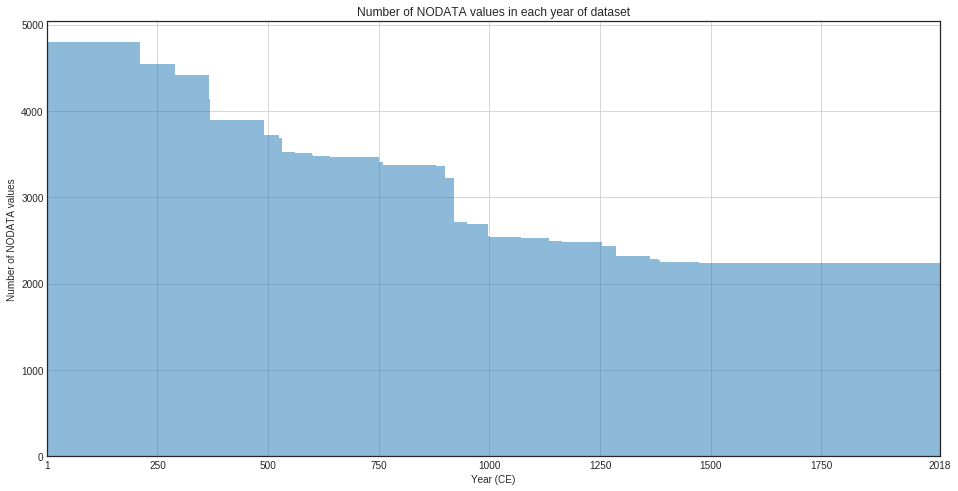

In [25]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1,1,1)
ax.set_title("Number of NODATA values in each year of dataset")
ax.set_xlabel('Year (CE)')
ax.set_ylabel("Number of NODATA values")
ax.set_xlim(1,2018)
ax.set_xticks([1] + list(plt.xticks()[0][1:-2]) + [2018])
ax.grid(True)
ax.bar(x=range(1,2019), height=missing_data_by_year, width=1, alpha=0.5);

# Create dashboard for browsing data year by year

In [26]:
def plot_contours(year=1):
    x = np.linspace(-124.5, -67, 115)
    y = np.linspace(49, 25, 48)
    plt.figure(figsize=(16,8))
    X, Y = np.meshgrid(x, y)
    plt.contourf( X, Y, full_dataset_masked_array[year-1], 20, cmap='jet', vmin=-8, vmax=+7)
    plt.colorbar();

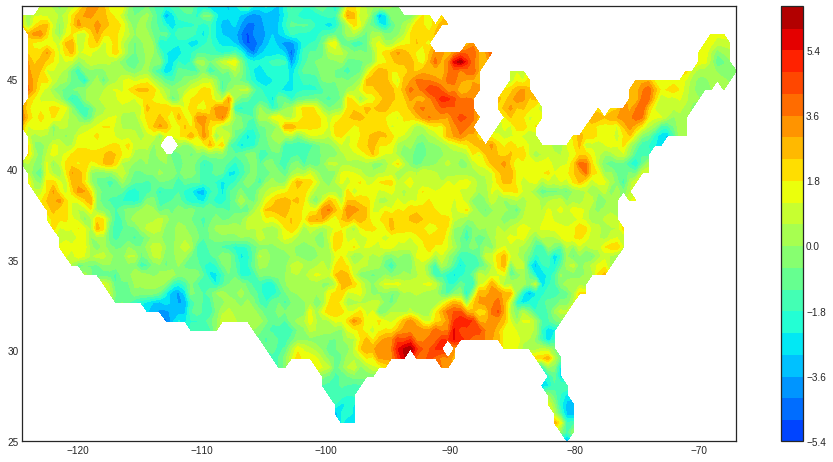

In [27]:
%matplotlib inline
plt.style.use('seaborn-white')

plot_contours(year=2018)